# Checking using wider/narrower priors

For the CIAM socioeconomic parameters

In [26]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re, os
import matplotlib.pyplot as plt
%matplotlib inline

Colorblind-friendly palette

In [27]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [28]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [29]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


In [30]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]
surge_option = 0
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

### Initialize some dicts of DataFrames 

Different dict eleemnts correspond to different SSP/RCP scenarios

In [31]:
dfSC = {scen : None for scen in scenarios}
dfSC_wide = {scen : None for scen in scenarios}
dfSC_narr = {scen : None for scen in scenarios}

## Read Monte Carlo simulation results

In [34]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

In [35]:
for (ssp,rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    widedir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM_wider/CIAM MC1000/PostProcessing"
    narrdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM_narrower/CIAM MC1000/PostProcessing"        

    dfSC[(ssp,rcp)] = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfO = pd.read_csv(bothdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfSC[(ssp,rcp)] = subtract_ref_npv(dfO,dfSC[(ssp,rcp)])
    
    # wider
    dfSC_wide[(ssp,rcp)] = pd.read_csv(widedir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM_wider.csv")
    dfO = pd.read_csv(widedir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM_wider.csv")
    dfSC_wide[(ssp,rcp)] = subtract_ref_npv(dfO,dfSC_wide[(ssp,rcp)])
    
    # narrower
    dfSC_narr[(ssp,rcp)] = pd.read_csv(narrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM_narrower.csv")
    dfO = pd.read_csv(narrdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM_narrower.csv")
    dfSC_narr[(ssp,rcp)] = subtract_ref_npv(dfO,dfSC_narr[(ssp,rcp)])
    

### Histogram

KDE version

In [37]:
x = np.linspace(0,12000,500)
kde = {scen : {} for scen in scenarios}
kde_plot = {scen : {} for scen in scenarios}
for scen in scenarios:
    kde[scen]["Orig"] = stats.gaussian_kde(dfSC[scen].npv)
    kde[scen]["Wide"] = stats.gaussian_kde(dfSC_wide[scen].npv)
    kde[scen]["Narrow"] = stats.gaussian_kde(dfSC_narr[scen].npv)
    for k in kde[scen].keys():
        kde_plot[scen][k] = kde[scen][k](x)

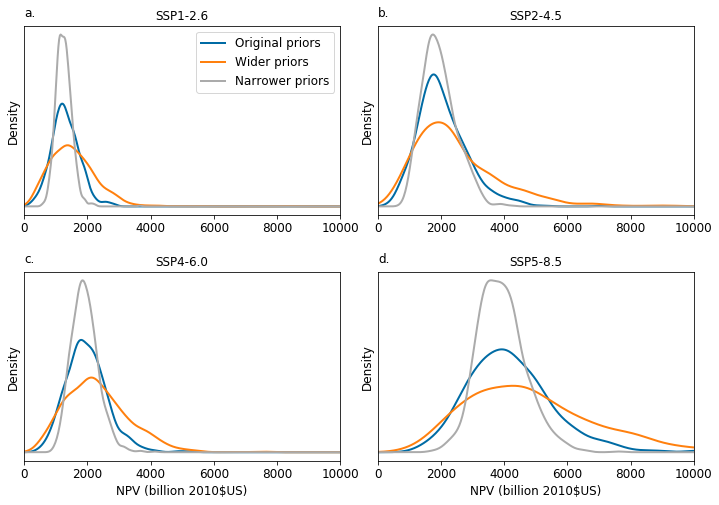

In [38]:
titles = ["SSP1-2.6", "SSP2-4.5", "SSP4-6.0", "SSP5-8.5"]
fig, ax = plt.subplots(2,2,figsize=(12,8))
for s in range(4):
    scen = scenarios[s]
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["Orig"], linewidth=2, color="C0", label="Original priors")
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["Wide"], linewidth=2, color="C1", label="Wider priors")
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["Narrow"], linewidth=2, color="C2", label="Narrower priors")
    if s==2 or s==3:
        ax[int(s/2)][s%2].set_xlabel("NPV (billion 2010$US)", fontsize=12); 
    ax[int(s/2)][s%2].set_ylabel("Density", fontsize=12); ax[int(s/2)][s%2].set_yticks([])
    ax[int(s/2)][s%2].set_xlim([0,10000]); ax[int(s/2)][s%2].set_xticklabels(list(range(0,12000,2000)),fontsize=12)
    if s==0:
        ax[int(s/2)][s%2].legend(fontsize=12, frameon=True)
    ax[int(s/2)][s%2].text(0,ax[int(s/2)][s%2].get_ylim()[1]*1.05,panels[s],fontsize=12)
    ax[int(s/2)][s%2].set_title(titles[s], fontsize=12)
plt.subplots_adjust(hspace=0.3, wspace=0.12)
fig.savefig(plotdir+"/global_damages_ssprcp_widerNarrowerPriors.pdf", bbox_inches='tight');

In [39]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]
for scen in scenarios:
    ssp,rcp = scen
    dfOut = pd.DataFrame(data={"percentile" : percentiles_out,
                               "Original"   : dfSC[scen].npv.quantile(percentiles_out),
                               "Wider"      : dfSC_wide[scen].npv.quantile(percentiles_out),
                               "Narrower"   : dfSC_narr[scen].npv.quantile(percentiles_out)
                              })
    filename_out = datdir+"/FigureData_global_totalNPV_ensembles_SSP"+str(ssp)+"-RCP"+str(rcp)+"_widerNarrowPriors.csv"
    dfOut.to_csv(filename_out, index=False)
    print((ssp,rcp))
    print(np.round(dfOut,3))

(1, 26)
       percentile  Original     Wider  Narrower
0.000       0.000   134.468   225.481   575.878
0.010       0.010   382.153   334.040   755.866
0.025       0.025   495.524   401.933   812.578
0.050       0.050   619.916   524.281   887.736
0.170       0.170   913.829   855.690  1026.982
0.250       0.250  1018.307  1008.240  1089.373
0.500       0.500  1273.826  1463.320  1239.608
0.750       0.750  1591.302  1976.488  1404.550
0.830       0.830  1717.541  2179.904  1469.046
0.950       0.950  2017.426  2820.626  1661.566
0.975       0.975  2242.629  3054.504  1760.966
0.990       0.990  2582.447  3575.590  1920.346
1.000       1.000  2918.408  8270.062  3662.580
(2, 45)
       percentile  Original     Wider  Narrower
0.000       0.000   342.120   397.738   820.019
0.010       0.010   656.818   579.890   995.238
0.025       0.025   777.882   678.108  1065.195
0.050       0.050   942.526   853.858  1176.161
0.170       0.170  1358.575  1306.851  1425.211
0.250       0.250  1516.